# Динамика багов: приоритеты, выполнение и задержки

In [7]:
# Для анализа данных и обработки
import pandas as pd
import pandasql as psql

#Для визуализации данных
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# HTTP-запрос
import requests

# Параметры кодировки в URL-адресе
from urllib.parse import urlencode

In [8]:
# Функция для подключения и обработки .csv файла
def download_yandex_csv(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    
    response = requests.get(final_url)
    response.raise_for_status()  # Проверяем, что запрос прошел успешно
    
    download_url = response.json()['href']
    csv_response = requests.get(download_url)
    csv_response.raise_for_status()  # Проверяем, что скачивание файла прошло успешно
    
    df = pd.read_csv(download_url)
    return df

# Ссылки на публичные ключи
public_key_reg_data = 'https://disk.yandex.ru/d/gyq1hTYfciXZ3w'

# Создаем DataFrame для каждого файла
df = download_yandex_csv(public_key_reg_data)

## Описание столбцов:
1. **id** – Идентификатор/уникальный код задачи, используемый для отслеживания задачи.
2. **date_creation** – Дата и время создания задачи.
3. **date_update** – Дата и время последнего обновления задачи.
4. **task_name** – Имя или описание задачи, которое помогает понять, что конкретно нужно сделать.
5. **task_status** – Текущий статус задачи. Указывает, на какой стадии находится задача.
6. **stage** – Этап или стадия выполнения задачи. Это определяет, в какой рабочей области находится задача.
7. **executor_team** – Команда, назначенная для выполнения задачи. Определяет команду исполнителей задачи.
8. **task_type** – Тип задачи. Указывает на категорию задачи.
9. **priority_general** – Общий приоритет задачи. Помогает оценить важность задачи.
10. **deadline** – Дедлайн выполнения задачи. Крайний срок завершения задачи.
11. **sprint_name** – Название спринта, если задача привязана к конкретному спринту.
12. **sprint_date_start** – Дата начала спринта.
13. **sprint_date_finish** – Дата завершения спринта.
14. **is_subtask** – Указывает, является ли задача подзадачей (0 – нет, 1 – да).
15. **parent_id** – Идентификатор родительской задачи, если задача является подзадачей.
16. **dev_team** – Команда разработчиков, ответственных за задачу.
17. **dev_team_lead** – Лидер команды разработчиков.
18. **general_type** – Общий тип задачи. Указывает на категорию задачи.
19. **product_team** – Команда, связанная с продуктом, возможно отвечает за продуктовую часть задачи.
20. **is_last** – Флаг, указывающий, является ли это последняя версия задачи (0 – нет, 1 – да).

## 1. Фильтрация багов

Задачи с типом "инцидент" являются багами. Для начала отфильтруем их:

In [9]:
# Фильтрация задач типа "инцидент"
df_bugs = df[df['task_type'].str.contains('инцидент', case=False, na=False)]

# Выводи данные для проверки
df_bugs.head()

,id,date_creation,date_update,task_name,task_status,stage,executor_team,task_type,priority_general,deadline,...,sprint_name,sprint_date_start,sprint_date_finish,is_subtask,parent_id,dev_team,dev_team_lead,general_type,product_team,is_last
0,ВВ-36446,2024-01-02 07:14:48,2024-01-02 07:18:12,02.01.24_КМ►При выборе конкретного слота появл...,В работе,BackLog (ВВ),Группа ВкусВилл Интегратор. TEAM 1,Инцидент - БАГ,3. Средний,2024-02-16 07:14:48,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Задача,NaN,0
1,ВВ-36446,2024-01-02 07:14:48,2024-01-15 02:37:50,02.01.24_КМ►При выборе конкретного слота появл...,Отменено,Отменить задание,Группа ВкусВилл Интегратор. TEAM 1,Инцидент - БАГ,3. Средний,2024-02-16 07:14:48,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Задача,NaN,1
2,ВВ-36447,2024-01-02 07:19:47,2024-01-02 07:22:34,02.01.24_КМ► При попытке положить товар в корз...,В работе,BackLog (ВВ),Группа ВкусВилл Интегратор. TEAM 1,Инцидент - БАГ,4. Низкий,2024-04-01 07:19:47,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Задача,NaN,0
3,ВВ-36447,2024-01-02 07:19:47,2024-01-02 13:05:54,02.01.24_КМ► При попытке положить товар в корз...,В работе,BackLog (ВВ),Группа ВкусВилл Интегратор. TEAM 1,Инцидент - БАГ,4. Низкий,2024-04-01 07:19:47,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Задача,NaN,0
4,ВВ-36447,2024-01-02 07:19:47,2024-01-09 15:45:55,02.01.24_КМ► При попытке положить товар в корз...,В работе,BackLog (ВВ),Группа ВкусВилл Интегратор. TEAM 3,Инцидент - БАГ,4. Низкий,2024-04-01 07:19:47,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Задача,NaN,0


### Вывод
Видим что вывелись необходимые данные

## 2. Метрики

### Метрика 1: Количество багов и динамика их появления

Динамика багов поможет понять, как часто они возникают. Для этого сгруппируем баги по дате создания:

In [ ]:
# Преобразуем столбец с датами в формат datetime
df_bugs['date_creation'] = pd.to_datetime(df_bugs['date_creation'])

# Считаем количество багов по дням
bugs_count_by_day = df_bugs.groupby(df_bugs['date_creation'].dt.date).size()

# Дополнительные текстовые данные и цифры
total_bugs = df_bugs.shape[0]
average_bugs_per_day = bugs_count_by_day.mean()
date_with_max_bugs = bugs_count_by_day.idxmax()
max_bugs = bugs_count_by_day.max()

print(f"Общее количество багов: {total_bugs}")
print(f"Среднее количество багов в день: {average_bugs_per_day:.2f}")
print(f"Максимальное количество багов в один день: {max_bugs} (Дата: {date_with_max_bugs})")

# Создание интерактивного графика
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=bugs_count_by_day.index,
    y=bugs_count_by_day.values,
    mode='lines+markers',
    name='Количество багов',
    line=dict(color='royalblue', width=2),
    marker=dict(size=6, color='royalblue')
))

# Добавляем аннотации для максимального количества багов
fig.add_annotation(
    x=date_with_max_bugs,
    y=max_bugs,
    text=f"Максимум: {max_bugs}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40
)

# Настройки макета
fig.update_layout(
    title='Динамика количества багов',
    xaxis_title='Дата',
    yaxis_title='Количество багов',
    xaxis=dict(
        title='Дата',
        tickformat='%Y-%m-%d',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Количество багов',
        showgrid=True,
        zeroline=False
    ),
    template='plotly_white',
    hovermode='x unified'
)

# Показываем график
fig.show()

Общее количество багов: 13403
Среднее количество багов в день: 83.25
Максимальное количество багов в один день: 263 (Дата: 2024-02-29)


### Вывод 

**Общее количество багов:** 13,403

**Среднее количество багов в день:** 83.25

**Максимальное количество багов в один день:** 263 (Дата: 2024-02-29)

**Анализ:**

1. **Среднее количество багов в день:** В среднем в день регистрируется 83.25 бага. Это значение дает общее представление о нагрузке на команду и может использоваться для планирования ресурсов и оценки производительности.

2. **Дата с максимальным количеством багов:** 29 февраля 2024 года выделяется как день с самым большим количеством багов. Это может быть вызвано особыми обстоятельствами, такими как релиз нового функционала или другой важный фактор, влияющий на количество багов.

### Метрика 2: Способность команд справляться с багами (очередь задач)

Проанализируем, в каких статусах находятся баги (в работе, выполнено, отменено и т.д.), чтобы понять, насколько команды справляются с багами.

Общее количество багов: 13403
Статус с наибольшим количеством багов: В работе (11902 багов)

Количество инцидентов по статусам:
В работе: 11902 инцидентов
Закрыто: 913 инцидентов
Отменено: 588 инцидентов


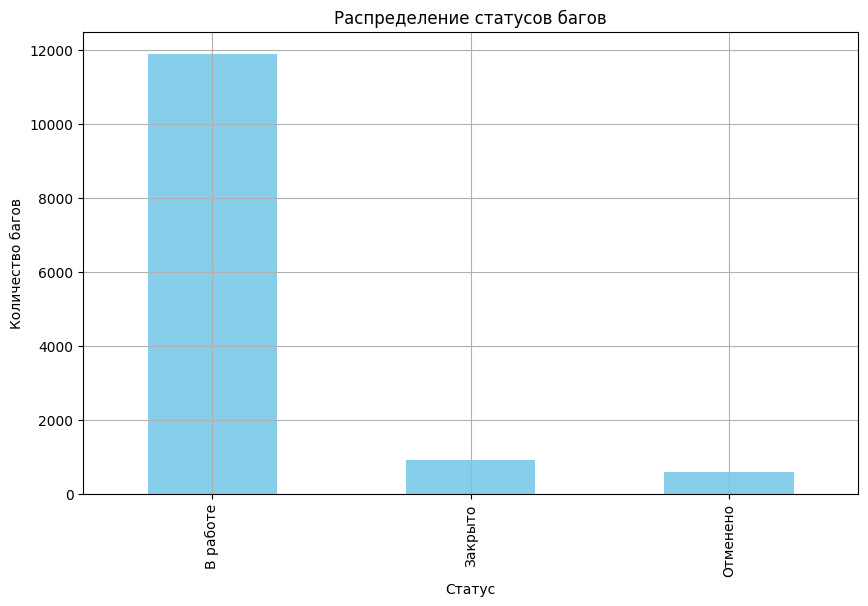

In [5]:
# Подсчитываем количество багов по статусу
status_counts = df_bugs['task_status'].value_counts()

# Дополнительные текстовые данные и цифры
total_bugs = df_bugs.shape[0]
most_common_status = status_counts.idxmax()
max_status_count = status_counts.max()

# Фильтруем строки, где тип задачи содержит "Инцидент"
incident_bugs = df_bugs[df_bugs['task_type'].str.contains('Инцидент', case=False, na=False)]

# Подсчитываем количество инцидентов по статусам
incident_status_counts = incident_bugs['task_status'].value_counts()

# Вывод данных
print(f"Общее количество багов: {total_bugs}")
print(f"Статус с наибольшим количеством багов: {most_common_status} ({max_status_count} багов)")
print("\nКоличество инцидентов по статусам:")
for status, count in incident_status_counts.items():
    print(f"{status}: {count} инцидентов")

# Визуализируем распределение статусов багов
plt.figure(figsize=(10, 6))
status_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение статусов багов')
plt.xlabel('Статус')
plt.ylabel('Количество багов')
plt.grid(True)
plt.show()

### Вывод 
**Общее количество багов:** 13,403

**Статус с наибольшим количеством багов:** "В работе" — 11,902 багов

**Количество инцидентов по статусам:**

- **В работе:** 11,902 инцидентов
- **Закрыто:** 913 инцидентов
- **Отменено:** 588 инцидентов

**Анализ:**

1. **Доминантный статус**: Значительное количество багов находится в статусе "В работе", что составляет 88.9% от общего числа багов. Это может указывать на высокую рабочую нагрузку и необходимость увеличения ресурсов или улучшения процессов для обработки этих инцидентов.

2. **Закрытые инциденты**: Сравнительно небольшое количество багов (6.8%) отмечено как "Закрыто". Это может свидетельствовать о том, что процессы закрытия инцидентов требуют улучшения или же инциденты решаются менее эффективно.

3. **Отмененные инциденты**: Количество "Отмененных" инцидентов составляет 4.4%. Это также стоит учитывать, так как высокий процент отмененных инцидентов может указывать на проблемы в первоначальной оценке или приоритизации задач.

### Метрика 3: Какие баги стоит брать в работу в первую очередь

Для приоритизации багов важно учитывать приоритет задачи и дедлайн. Например, баги с высоким приоритетом и ближайшими дедлайнами должны быть в работе в первую очередь.

In [6]:
# Фильтрация багов с высоким приоритетом
df_high_priority_bugs = df_bugs[df_bugs['priority_general'] == '1. Молния']

# Сортировка по дедлайну
df_high_priority_bugs = df_high_priority_bugs.sort_values('deadline')

# Показать несколько багов, которые нужно брать в работу в первую очередь
df_high_priority_bugs[['id', 'task_name', 'priority_general', 'deadline']].head(10)

,id,task_name,priority_general,deadline
613,ВВ-38238,Красный крест при записи Физ. лица в ЗУП,1. Молния,2024-01-16 10:40:29
850,ВВ-38866,При списание товара на ПСЕ он падает на остато...,1. Молния,2024-01-17 18:43:41
851,ВВ-38866,При списание товара на ПСЕ он падает на остато...,1. Молния,2024-01-17 18:43:41
852,ВВ-38866,При списание товара на ПСЕ он падает на остато...,1. Молния,2024-01-17 18:43:41
853,ВВ-38866,При списание товара на ПСЕ он падает на остато...,1. Молния,2024-01-17 18:43:41
868,ВВ-38867,При инвентаризации на ОСЕ подсвечивается красн...,1. Молния,2024-01-17 18:47:10
867,ВВ-38867,При инвентаризации на ОСЕ подсвечивается красн...,1. Молния,2024-01-17 18:47:10
869,ВВ-38867,При инвентаризации на ОСЕ подсвечивается красн...,1. Молния,2024-01-17 18:47:10
865,ВВ-38867,При инвентаризации на ОСЕ подсвечивается красн...,1. Молния,2024-01-17 18:47:10
864,ВВ-38867,При инвентаризации на ОСЕ подсвечивается красн...,1. Молния,2024-01-17 18:47:10


### Вывод
Выявлено 10 багов с приоритетом "1. Молния". Из которых 9 в один день 2024-01-17 и почти в тоже время, и лишь один 2024-01-16.

### Время решения багов

Важно также проанализировать, насколько быстро решаются баги, чтобы увидеть, как команды справляются с проблемами. Рассчитаем среднее время решения:

In [7]:
# Преобразуем даты обновления в формат datetime
df_bugs['date_update'] = pd.to_datetime(df_bugs['date_update'])

# Рассчитываем время решения багов в днях
df_bugs['resolution_time'] = (df_bugs['date_update'] - df_bugs['date_creation']).dt.days

# Рассчитываем среднее время решения багов
average_resolution_time = df_bugs['resolution_time'].mean()
print(f'Среднее время решения багов: {average_resolution_time:.2f} дня')

Среднее время решения багов: 14.77 дня


### Вывод
**Среднее время решения багов:** В среднем решение бага занимает 14.77 дня. Это значение предоставляет представление о времени, необходимом для устранения инцидентов и может быть использовано для оценки эффективности команды и процессов.

## Нагрузка на команды

Посмотрим, сколько багов приходится на каждую команду:

Общее количество команд: 88
Команда с наибольшим количеством багов: Группа ВкусВилл Интегратор. TEAM 6 (1139 багов)


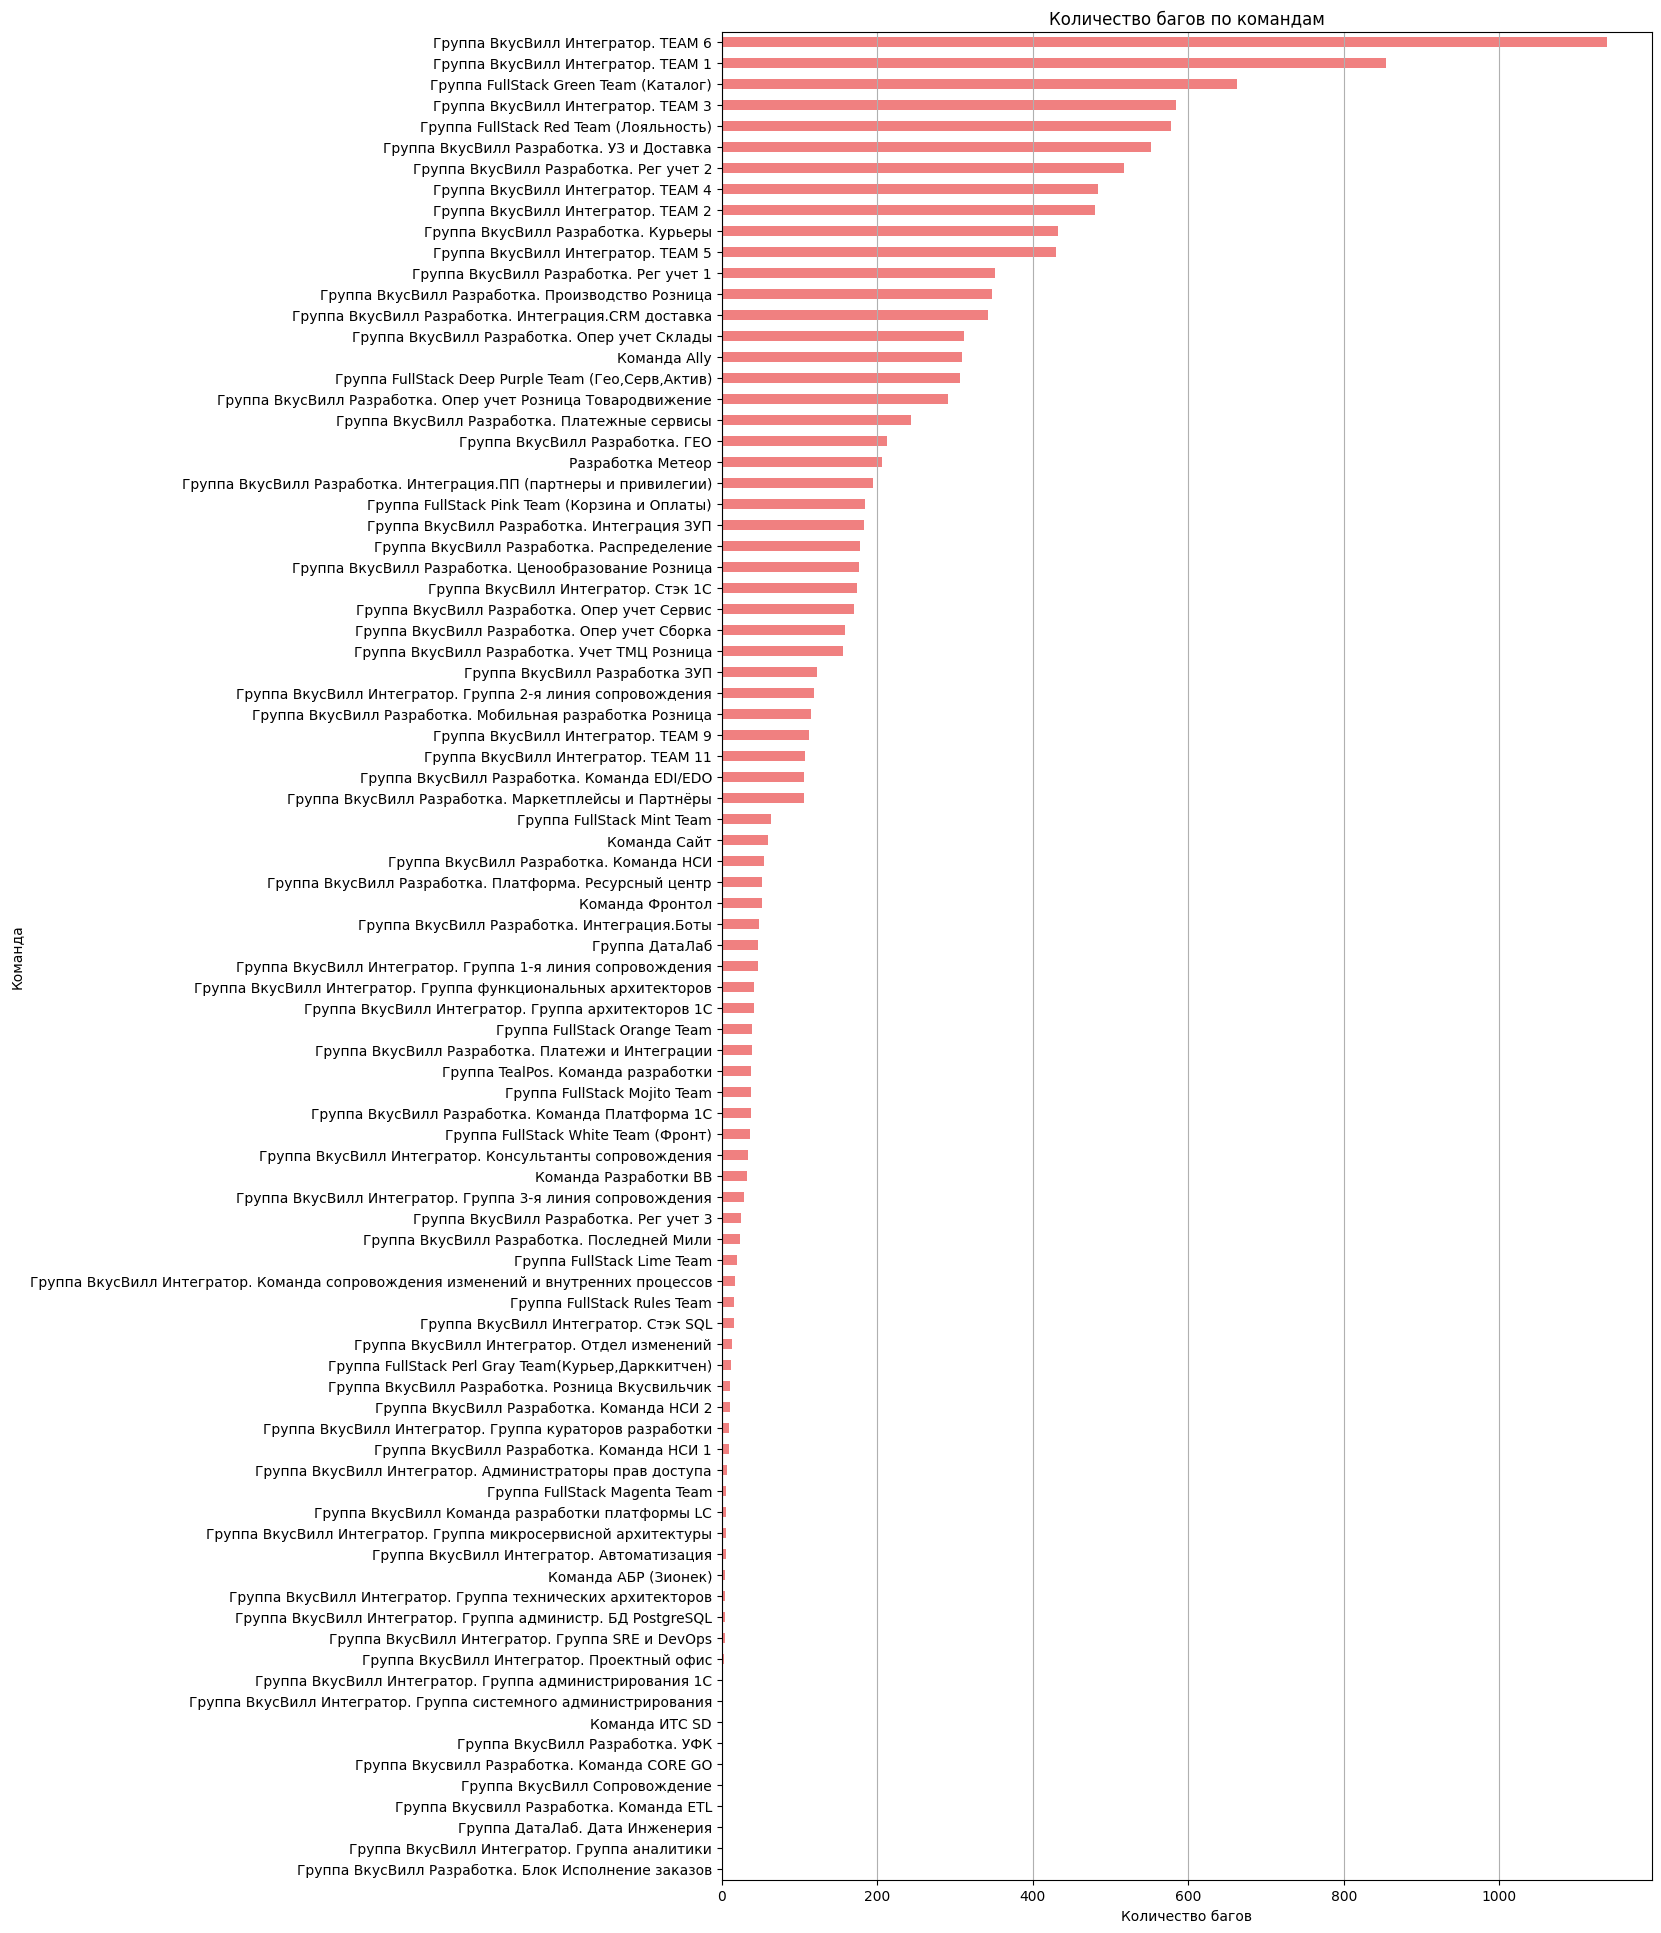

In [8]:
# Подсчет багов по командам исполнителей
bugs_by_team = df_bugs['executor_team'].value_counts()

# Сортируем данные по убыванию
sorted_bugs_by_team = bugs_by_team.sort_values(ascending=True)

# Дополнительные текстовые данные и цифры
total_teams = sorted_bugs_by_team.shape[0]
most_bugs_team = sorted_bugs_by_team.idxmax()
max_bugs_by_team = sorted_bugs_by_team.max()

print(f"Общее количество команд: {total_teams}")
print(f"Команда с наибольшим количеством багов: {most_bugs_team} ({max_bugs_by_team} багов)")

# Визуализируем нагрузку на команды
plt.figure(figsize=(12, 24))  # Изменяем размеры графика
sorted_bugs_by_team.plot(kind='barh', color='lightcoral')  # Изменяем тип графика на горизонтальный столбец
plt.title('Количество багов по командам')
plt.xlabel('Количество багов')
plt.ylabel('Команда')
plt.grid(True, axis='x')  # Сетка по оси X
plt.show()

## Вывод 
Общее количество команд: В проекте задействовано 88 команд. Это указывает на широкую организационную структуру и распределение задач между различными группами.

Команда с наибольшим количеством багов: Команда "Группа ВкусВилл Интегратор. TEAM 6" имеет наибольшее количество багов — 1,139. Это составляет значительную часть от общего числа багов и может указывать на высокую нагрузку или сложности в работе этой команды.

## Общий вывод

- **Общее количество багов:** 13,403
- **Среднее количество багов в день:** 83.25
- **Максимальное количество багов в один день:** 263 (29 февраля 2024 года)
- **Среднее время решения багов:** 14.77 дня

**Статусы багов:**
- В работе: 11,902
- Закрыто: 913
- Отменено: 588

**Команды:**
- **Общее количество команд:** 88
- **Команда с наибольшим количеством багов:** "Группа ВкусВилл Интегратор. TEAM 6" (1,139 багов)

**Рекомендации:**
- Анализировать причины всплесков багов и высокую нагрузку на команду "TEAM 6".
- Оптимизировать процессы для сокращения времени решения багов.
- Обеспечить дополнительную поддержку и перераспределение ресурсов для команд с высоким количеством инцидентов.